## Transcriptome annotation on GCP

### Google Cloud Platform (GCP)

This notebook execute our workflow using the Google Cloud Life Sciences API. We explore different [machine types]( https://cloud.google.com/compute/docs/machine-types), first (N1) and second (N2) generation, and three number of CPUs for each machine type: 16, 32, and 64. We will call `configuration` to the combination of `MACHINE_TYPE/CPU`

The input data, transcriptome in FASTA file, is partitioned in the [01 - Data Partitioning.ipynb]( 01%20-%20Data%20Partitioning.ipynb). 20 FASTA files are created for each query size and are uploaded to a GCP storage bucket with prefixes: `nopal_2000_` for input data and `nopal_results_2000_` for the results files (2000 is for the query size processed and will be 2000, 6000 and 10000).

This notebook will create an organizational structure for storing the pipeline and logs files. It includes directories following the convention: `QUERY_SIZE/MACHINE_TYPE/CPU`. In addition, each `QUERY_SIZE` folder includes a `fasta` directory to store the FASTA files to be analyzed. See next directory tree for more information:

```bash
$ tree -dt ./results/PRJNA320545/
    ./results/PRJNA320545/
    ├── 10000
    │   ├── n1
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   ├── n2
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   └── fasta
    ├── 6000
    │   ├── n1
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   ├── n2
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   └── fasta
    └── 2000
        ├── n1
        │   ├── 64
        │   ├── 32
        │   └── 16
        ├── n2
        │   ├── 64
        │   ├── 32
        │   └── 16
        └── fasta

    30 directories
```

After completation, each configuration, `QUERY_SIZE/MACHINE_TYPE/CPU`, will include 22 files: 

* ` pipeline.json`: pipeline executed for that configuration.
* ` operations.tsv`: TSV file for relating FASTA file name with GCP operation ID and status
* `[1-20].json.gz`: Compressed GCP pipeline log for each operation.

```bash
    └── 2000
        └── n1
            └── 16
                ├── 10.json.gz
                ├── 11.json.gz
                ├── 12.json.gz
                ├── 13.json.gz
                ├── 14.json.gz
                ├── 15.json.gz
                ├── 16.json.gz
                ├── 17.json.gz
                ├── 18.json.gz
                ├── 19.json.gz
                ├── 1.json.gz
                ├── 20.json.gz
                ├── 2.json.gz
                ├── 3.json.gz
                ├── 4.json.gz
                ├── 5.json.gz
                ├── 6.json.gz
                ├── 7.json.gz
                ├── 8.json.gz
                ├── 9.json.gz
                ├── operations.tsv
                └── pipeline.json
```

The annotation files, output from the CWL workflow will be stored in the result bucket with prefix: `nopal_results_2000_`, each QUERY_SIZE bucket will include directories with name: `SAMPLE_MACHINE_TYPE_CPUs`, e.g. `2000_1_n1_16`, FASTA file `2000_1` output for machine type `n1` with `16` CPUs. 

### Requirements

#### [Cloud SDK](https://cloud.google.com/sdk)


Run *gcloud init* to initialize the gcloud environment and follow its instructions:

 `$ gcloud init`
 

### Loading packages from config/init.py

In [1]:
%run ../config/init.py

### Testing gcloud configuration

In [2]:
account = !gcloud config get-value account
account = ''.join(account)
project = !gcloud config get-value project
project = ''.join(project)
if account != '(unset)' and project != '(unset)':
    print('Using account: {} with project: {}'.format(account, project))
else:
    print('Please, configure Cloud SDK before running this notebook')
    print('Open a Terminal and run: gcloud init')

Using account: veraalva@ncbi.nih.gov with project: cbb-research-dl


### Installing gcloud beta components

In [3]:
!gcloud components install beta --quiet


All components are up to date.


### Defining variables

Edit GCP zone and region variable accordingly to your geographical location.

In [4]:
ZONE = 'us-east1'
REGION = 'us-east1-c'
USE_PREEMPTIBLE = False

| Provider | Instance Size | vCPU | Memory (GiB) | Instance Storage (GiB) | Network Bandwidth (Gbps) | \$/Hour | Preemptible \$/Hour |
|---------|---------|----------|----------|-------------|---------------|-----------|-----------|
| GCP | n1-standard-16 | 16 | 60 | 24 x 375 NVMe SSD | 32 | 0.861 | 0.16 |
| GCP | n1-standard-32 | 32 | 120 | 24 x 375 NVMe SSD | 32 | 1.393 | 0.32 |
| GCP | n1-standard-64 | 64 | 240 | 24 x 375 NVMe SSD | 32 | 2.475 | 0.64 |
| GCP | n2-standard-16 | 16 | 64 | 24 x 375 NVMe SSD | 32 | 0.951 | 0.18832 |
| GCP | n2-standard-32 | 32 | 128 | 24 x 375 NVMe SSD | 32 | 1.572 | 0.37664 |
| GCP | n2-standard-64 | 64 | 256 | 24 x 375 NVMe SSD | 32 | 2.816 | 0.75328 |


In [5]:
QUERY_SIZES = [2000, 6000, 10000]

MACHINE_TYPES = ['n1', 'n2']
CPUs = [16, 32, 64]

# Prices from 03/04/2020
PRICE = {
    'n1':{
        16: 0.861,
        32: 1.393,
        64: 2.475
    },
    'n2':{
        16: 0.951,
        32: 1.572,
        64: 2.816
    }    
}
PREEMPTIBLE_PRICE = {
    'n1':{
        16: 0.16,
        32: 0.32,
        64: 0.64
    },
    'n2':{
        16: 0.18832,
        32: 0.37664,
        64: 0.75328
    }    
}

PIPELINE_JSON = os.path.join(CONFIG, 'gcp', 'pipeline.json')
with open(PIPELINE_JSON) as fin:
    pipeline = json.load(fin)
    pipeline['resources']['zones'][0] = REGION
    pipeline['resources']['virtualMachine']['preemptible'] = USE_PREEMPTIBLE

In [224]:
result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)
print('Using as output directory: {}'.format(result_dir))

Using as output directory: /home/veraalva/cloud-transcriptome-annotation/results/PRJNA320545


### Create or retrieve GCP storage bucket

In [52]:
bucket_list = !gsutil ls
buckets = {}
for q in QUERY_SIZES:
    prefix = 'gs://nopal_' + str(q) + '_'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('gs://nopal_' + str(q) + '_','').replace('/','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal_' + str(q) + '_' + suffix
        outbucket = 'nopal_results_' + str(q) + '_' + suffix
        buckets[q] = suffix 
        
        !gsutil mb -l {ZONE} gs://{inbucket}
        !gsutil mb -l {ZONE} gs://{outbucket}
        !gsutil -m -o 'GSUtil:parallel_composite_upload_threshold=150M' -o 'GSUtil:parallel_process_count=16' -o 'GSUtil:parallel_thread_count=16' cp -R {q}/fasta/*.fa gs://{inbucket}/ 
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal_{0}_{1}\n\tout-bucket: nopal_results{0}_{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal_2000_434d451f-40b8-4dac-99a5-8fd1d5957fa3
	out-bucket: nopal_results2000_434d451f-40b8-4dac-99a5-8fd1d5957fa3
Query size: 6000
	in-bucket: nopal_6000_8b24b1d8-8872-43ce-a354-aa8f31802f4c
	out-bucket: nopal_results6000_8b24b1d8-8872-43ce-a354-aa8f31802f4c
Query size: 10000
	in-bucket: nopal_10000_73d4965d-c54a-45cf-a552-08e700820a80
	out-bucket: nopal_results10000_73d4965d-c54a-45cf-a552-08e700820a80


### Submitting the jobs to the AWS Batch

 
This code check if the log from GCP was downloaded and it was completed successfully. 

If the log does not exists or it failled the job will be marked to be submitted again.

In [225]:
bar_length = 20
jobs = {}
jobs_to_submit = 0
for q in QUERY_SIZES:
    jobs[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:
        jobs[q][m] = {}
        for c in CPUs:
            jobs[q][m][c] = {}
            instace_dir = os.path.join(q_dir, m, str(c))
            if not os.path.exists(instace_dir):
                os.makedirs(instace_dir)
            os.chdir(instace_dir)
            for i in range(1,21):
                if os.path.exists('{}.id'.format(i)):
                    jobs[q][m][c][i] = {'completed': True}
                else:
                    jobs_to_submit += 1
                    jobs[q][m][c][i] = {'completed': False}
print('{} jobs to be submitted'.format(jobs_to_submit))

0 jobs to be submitted


### Submitting jobs
After running this cell you should go to the [Google Cloud Console](https://console.cloud.google.com/compute) to visualize all running instances.

In [226]:
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    if q in jobs:    
        for m in MACHINE_TYPES:
            if m in jobs[q]:
                inbucket = 'nopal_' + str(q) + '_' + buckets[q]
                outbucket = 'nopal_results_' + str(q) + '_' + buckets[q]
                for c in CPUs:  
                    if c in jobs[q][m]:
                        instace_dir = os.path.join(q_dir, m, str(c))
                        os.chdir(instace_dir)
                        
                        pipeline['resources']['virtualMachine']['machineType'] = '{}-standard-{}'.format(m,c)
                        with open('pipeline.json', 'w') as f:
                            f.write(json.dumps(pipeline, indent=2))  
                        
                        submitted = 0
                        for i in range(1,21):
                            if i in jobs[q][m][c] and not jobs[q][m][c][i]['completed']:
                                submitted += 1
                                sample = '{}_{}'.format(q, i)                                
                                a = !gcloud beta lifesciences pipelines run --pipeline-file=pipeline.json --env-vars=N={m},CPUs={c},INBUCKET={inbucket},OUTBUCKET={outbucket},SAMPLE={sample}
                                if len(a) == 1 and a[0].startswith('Running'):
                                    a = a[0].replace('].','').split('/')[5]
                                    with open('{}.id'.format(i), 'w') as fout:
                                        fout.write(a) 
                            progress = i * 100/20
                            text = "{0}_{1}_{2}-standard-{3} [{4}] {5:3.1f}%  jobs submitted {6:3d}".format(q, i, m, c, "#" * i + "-" * (bar_length - i), progress, submitted)
                            print(text, end='\r') 
                        print()

2000_20_n1-standard-16 [####################] 100.0%  jobs submitted   0
2000_20_n1-standard-32 [####################] 100.0%  jobs submitted   0
2000_20_n1-standard-64 [####################] 100.0%  jobs submitted   0
2000_20_n2-standard-16 [####################] 100.0%  jobs submitted   0
2000_20_n2-standard-32 [####################] 100.0%  jobs submitted   0
2000_20_n2-standard-64 [####################] 100.0%  jobs submitted   0
6000_20_n1-standard-16 [####################] 100.0%  jobs submitted   0
6000_20_n1-standard-32 [####################] 100.0%  jobs submitted   0
6000_20_n1-standard-64 [####################] 100.0%  jobs submitted   0
6000_20_n2-standard-16 [####################] 100.0%  jobs submitted   0
6000_20_n2-standard-32 [####################] 100.0%  jobs submitted   0
6000_20_n2-standard-64 [####################] 100.0%  jobs submitted   0
10000_20_n1-standard-16 [####################] 100.0%  jobs submitted   0
10000_20_n1-standard-32 [####################] 100

### GCP log retrival for plotting
This cell will download the GCP logs for completed operations (jobs) creating the `[1-20].json` files for each configuration. 

You should executed it multiple times until all operations are completed. 

In [227]:
errors = []
total_no_completed = 0
for q in QUERY_SIZES:
    boxdata_total = []
    boxdata_blast = []
    boxdata_creation = []
    q_dir = os.path.join(result_dir, str(q))
    
    outbucket = 'nopal_results_' + str(q) + '_' + buckets[q]
    
    for m in MACHINE_TYPES:
        m_dir = os.path.join(q_dir, str(m))
        os.chdir(m_dir)
        for c in CPUs:
            
            c_dir = os.path.join(m_dir, str(c))
            os.chdir(c_dir)

            completed = 0
            failed = 0
            no_completed = 0

            data = []
            for i in range(1,21):
                if os.path.exists('{}.id'.format(i)):
                    mark_to_delete = False 
                    job_file = '{}.json.gz'.format(i)
                    job_log = '{}.log'.format(i)
                    outdir = '{}_{}_{}_{}'.format(q,i,m,c)
                        
                    with open('{}.id'.format(i)) as fin:
                        job_id = fin.read()                        
                        log = None                        
                        
                        if os.path.exists(job_file):
                            with gzip.GzipFile(job_file, 'r') as fin:  
                                completed += 1
                                log = json.loads(fin.read().decode('utf-8'))
                        else:                                
                            a = !gcloud beta lifesciences operations describe --format=json {job_id}
                            log = json.loads(''.join(a))
                            if 'done' in log:
                                is_completed = False
                                if not 'error' in log:
                                    !gsutil cp gs://{outbucket}/{outdir}/pipeline.log {job_log} 2> {i}_gsutil.log
                                    if os.path.exists(job_log):
                                        with open(job_log) as fin:                                    
                                            for line in fin.readlines():
                                                if 'Final process status is success' in line:
                                                    is_completed = True
                                                    break
                                if is_completed:
                                    with gzip.GzipFile(job_file, 'w') as fout:
                                        fout.write(json.dumps(log, indent=2).encode('utf-8'))
                                    completed += 1
                                else:
                                    if 'error' in log:
                                        errors.append([q,m,c, i, log['error']['code'], job_id])
                                    else:
                                        errors.append([q,m,c, i, 'cwl', job_id])
                                    log = None
                                    mark_to_delete = True
                            else:
                                no_completed += 1

                        if log:
                            d = parse_gcp_json(log, i)
                            if d:
                                data.append(d)
                    
                    if mark_to_delete:
                        !gsutil rm -r gs://{outbucket}/{outdir} 2>> {i}_gsutil.log
                        failed += 1
                        if os.path.exists(job_file):
                            os.remove(job_file)
                        if os.path.exists(job_log):
                            os.remove(job_log)
                        os.remove('{}.id'.format(i))
                progress = i * 100/20
                text = "{0}_{1}_{2}-standard-{3} [{4}] {5:3.1f}%\tQuery: {6} Completed {7:3d} Failed {8:3d} No completed {9:3d}".format(q, i, m, c, "#" * i + "-" * (bar_length - i), progress, q, completed, failed, no_completed)
                print(text, end='\r')                    
            
            jobs[q][m][c]['gcp'] = pandas.DataFrame(data, columns=['id', 'GCP', 'BlastDB', 'CWL'])
            platform = 'GCP\n{}\n{}'.format(m.upper(), c)
            for i, r in jobs[q][m][c]['gcp'].iterrows():
                boxdata_total.append([r['GCP']/pandas.Timedelta('1 minute'), platform])
                boxdata_blast.append([r['BlastDB']/pandas.Timedelta('1 minute'), platform])
                boxdata_creation.append([r['GCP']/pandas.Timedelta('1 minute') - (r['CWL']/pandas.Timedelta('1 minute') + r['BlastDB']/pandas.Timedelta('1 minute')), platform])
            print()
            
            total_no_completed += no_completed + (20 - completed)
            
    jobs[q]['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Platform'])
    jobs[q]['total'].to_csv('gcp_total.tsv', sep='\t', index=None)
    jobs[q]['blast'] = pandas.DataFrame(boxdata_blast, columns=['Time', 'Platform'])
    jobs[q]['blast'].to_csv('gcp_blast.tsv', sep='\t', index=None)
    jobs[q]['creation'] = pandas.DataFrame(boxdata_creation, columns=['Time', 'Platform'])
    jobs[q]['creation'].to_csv('gcp_creation.tsv', sep='\t', index=None)
print()
errors = pandas.DataFrame(errors, columns=['Query', 'Machine Type', 'CPU', 'File', 'Error', 'operation'])
if errors.empty and total_no_completed == 0:
    print('Jobs completed. Proceed to the next cell')
else:
    if not errors.empty:
        print('There are errors')
        display(errors)
    if total_no_completed != 0:
        print('There are {} jobs not completed or to be submitted.'.format(total_no_completed))

2000_20_n1-standard-16 [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
2000_20_n1-standard-32 [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
2000_20_n1-standard-64 [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
2000_20_n2-standard-16 [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
2000_20_n2-standard-32 [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
2000_20_n2-standard-64 [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
6000_20_n1-standard-16 [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
6000_20_n1-standard-32 [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
6000_20_n1-standard-64 [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
6000_20_n2-standard-16 [#############

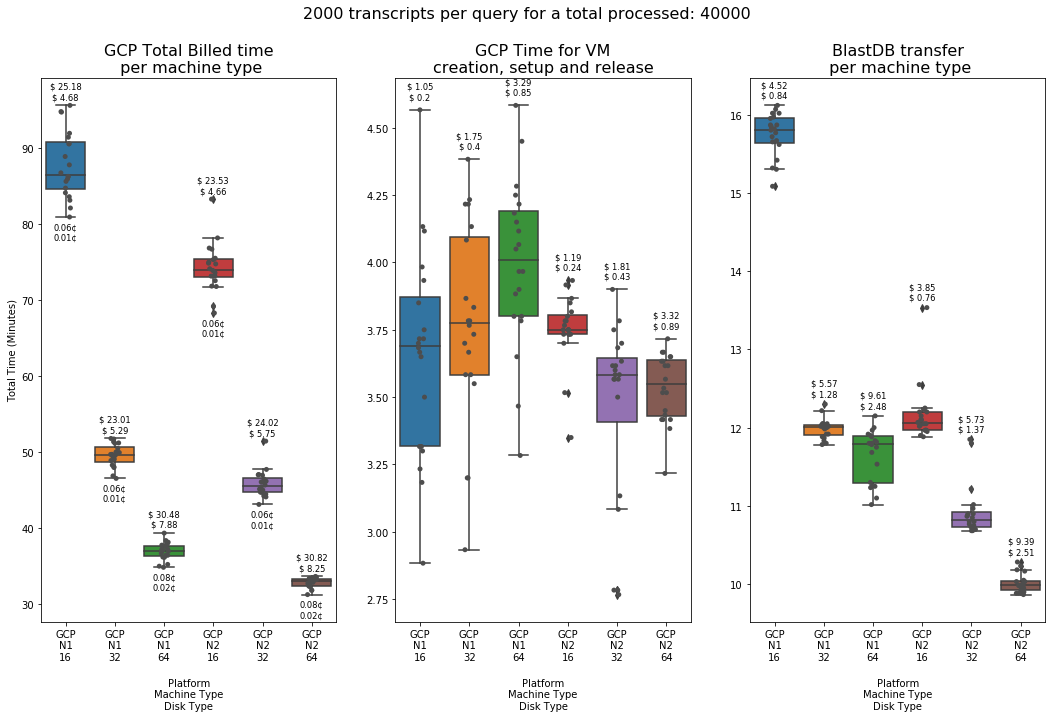

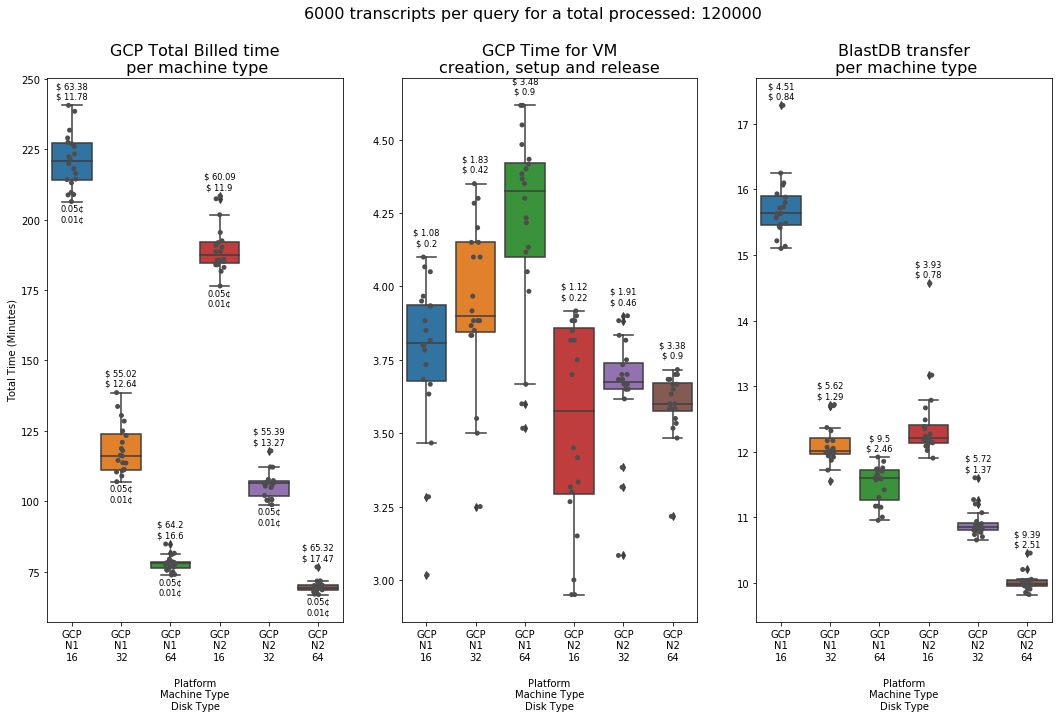

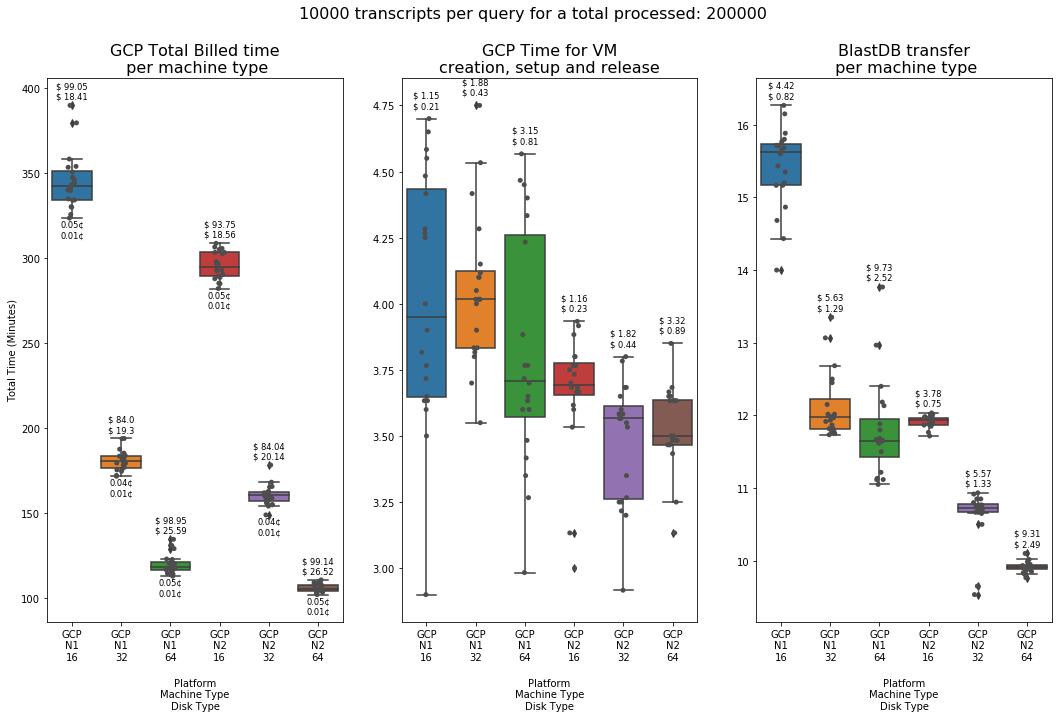

In [228]:
for q in QUERY_SIZES:
    df_total = jobs[q]['total']
    df_blast = jobs[q]['blast']
    df_creation = jobs[q]['creation']

    fig, axs = plt.subplots(figsize=(18,10), ncols=3)

    fig.suptitle(locale.format_string("%d", int(q), grouping=True)
                         + ' transcripts per query for a total processed: ' 
                         + locale.format_string("%d", int(q) * 20, grouping=True)
                 + '\n\n', fontsize=16)

    j=0

    top = []
    low = []
    billed = []
    cost = []
    for p in df_total['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_total[df_total['Platform'] == p]['Time'].max())
        low.append(df_total[df_total['Platform'] == p]['Time'].min())
        billed.append('$ {}\n$ {}'.format(
            round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2),
            round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PREEMPTIBLE_PRICE[f[1]][int(f[2])], 2),
        ))
        cost.append('{:.2f}¢\n{:.2f}¢'.format(
            df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])] * 100/(int(q) * 20),
            df_total[df_total['Platform'] == p]['Time'].sum()/60 * PREEMPTIBLE_PRICE[f[1]][int(f[2])] * 100/(int(q) * 20)
        ))


    box_plot = sns.boxplot(x="Platform", y="Time", data=df_total, ax=axs[j])
    
    top_tick = 0.8
    low_tick = 3.0
    if q == 6000:
        top_tick += 1.6
        low_tick += 4.0
    elif q == 10000:
        top_tick += 3.0
        low_tick += 8.4

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_total, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("Total Time (Minutes)")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("GCP Total Billed time\n per machine type", fontsize=16)

    j = 1

    top = []
    billed = []
    for p in df_creation['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_creation[df_creation['Platform'] == p]['Time'].max())
        billed.append('$ {}\n$ {}'.format(
            round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2),
            round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * PREEMPTIBLE_PRICE[f[1]][int(f[2])], 2)
        ))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_creation, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.04,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_creation, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("GCP Time for VM\ncreation, setup and release", fontsize=16)

    j = 2

    top = []
    billed = []
    for p in df_blast['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_blast[df_blast['Platform'] == p]['Time'].max())
        billed.append('$ {}\n$ {}'.format(
            round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2),
            round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * PREEMPTIBLE_PRICE[f[1]][int(f[2])], 2)
        ))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_blast, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.1,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_blast, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("BlastDB transfer\n per machine type", fontsize=16)


## Processing 120k transcripts using query sizes of 2k, 6k and 10k


In [233]:
result_dir = os.path.join(RESULTS, DATASET, '120k')
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)

### Creating storage bucket

In [8]:
bucket_list = !gsutil ls
buckets = {}
for q in QUERY_SIZES:
    prefix = 'gs://nopal_120k_' + str(q) + '_'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('gs://nopal_120k_' + str(q) + '_','').replace('/','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal_120k_' + str(q) + '_' + suffix
        outbucket = 'nopal_results_120k_' + str(q) + '_' + suffix
        buckets[q] = suffix 
        
        !gsutil mb -l {ZONE} gs://{inbucket}
        !gsutil mb -l {ZONE} gs://{outbucket}
        !gsutil -m -o 'GSUtil:parallel_composite_upload_threshold=150M' -o 'GSUtil:parallel_process_count=16' -o 'GSUtil:parallel_thread_count=16' cp -R {q}/fasta/*.fa gs://{inbucket}/ 
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal_120k_{0}_{1}\n\tout-bucket: nopal_120k_results{0}_{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal_120k_2000_cb4067ef-1ad0-407f-b862-7ef4c5df8871
	out-bucket: nopal_120k_results2000_cb4067ef-1ad0-407f-b862-7ef4c5df8871
Query size: 6000
	in-bucket: nopal_120k_6000_ba32ce6d-2112-444f-9f83-c97dbb50dacd
	out-bucket: nopal_120k_results6000_ba32ce6d-2112-444f-9f83-c97dbb50dacd
Query size: 10000
	in-bucket: nopal_120k_10000_d84ea3df-0f8d-4939-b33a-47a683787159
	out-bucket: nopal_120k_results10000_d84ea3df-0f8d-4939-b33a-47a683787159


In [234]:
bar_length = 20
jobs = {}
jobs_to_submit = 0
for q in QUERY_SIZES:
    jobs[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
    m = 'n2'
    c = 64
    instace_dir = os.path.join(q_dir, m, str(c))
    if not os.path.exists(instace_dir):
        os.makedirs(instace_dir)
    os.chdir(instace_dir)
    for s in samples:
        if os.path.exists('{}.id'.format(s)):
            jobs[q][s] = {'completed': True}
        else:
            jobs_to_submit += 1
            jobs[q][s] = {'completed': False}
print('{} jobs to be submitted'.format(jobs_to_submit))

0 jobs to be submitted


### Submitting jobs
After running this cell you should go to the [Google Cloud Console](https://console.cloud.google.com/compute) to visualize all running instances.

In [10]:
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    if q in jobs:  
        samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
        bar_length = len(samples)
        m = 'n2'
        c = 64
        inbucket = 'nopal_120k_' + str(q) + '_' + buckets[q]
        outbucket = 'nopal_results_120k_' + str(q) + '_' + buckets[q]
        instace_dir = os.path.join(q_dir, m, str(c))
        os.chdir(instace_dir)
                        
        pipeline['resources']['virtualMachine']['machineType'] = '{}-standard-{}'.format(m,c)
        with open('pipeline.json', 'w') as f:
            f.write(json.dumps(pipeline, indent=2))  
                        
        submitted = 0
        i = 1
        for s in samples:
            if s in jobs[q] and not jobs[q][s]['completed']:
                submitted += 1
                a = !gcloud beta lifesciences pipelines run --pipeline-file=pipeline.json --env-vars=N={m},CPUs={c},INBUCKET={inbucket},OUTBUCKET={outbucket},SAMPLE={s}
                if len(a) == 1 and a[0].startswith('Running'):
                    a = a[0].replace('].','').split('/')[5]
                    with open('{}.id'.format(s), 'w') as fout:
                        fout.write(a) 
            progress = i * 100/len(samples)
            text = "{0}_{1}_{2}-standard-{3} [{4}] {5:3.1f}%  jobs submitted {6:3d}".format(q, i, m, c, "#" * i + "-" * (bar_length - i), progress, submitted)
            print(text, end='\r') 
            i += 1
        print()

2000_60_n2-standard-64 [############################################################] 100.0%  jobs submitted  60


In [235]:
os.chdir(result_dir)
errors = []
total_no_completed = 0
boxdata_total = []
for q in QUERY_SIZES:    
    q_dir = os.path.join(result_dir, str(q))
    
    outbucket = 'nopal_results_120k_' + str(q) + '_' + buckets[q]
    samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
    bar_length = len(samples)
    m = 'n2'
    c = 64
            
    c_dir = os.path.join(q_dir, str(m), str(c))
    os.chdir(c_dir)

    completed = 0
    failed = 0
    no_completed = 0

    data = []
    i = 1
    for s in samples:
        if os.path.exists('{}.id'.format(s)):
            mark_to_delete = False 
            job_file = '{}.json.gz'.format(s)
            job_log = '{}.log'.format(s)
            outdir = '{}_{}_{}'.format(s,m,c)

            with open('{}.id'.format(s)) as fin:
                job_id = fin.read()                        
                log = None                        

                if os.path.exists(job_file):
                    with gzip.GzipFile(job_file, 'r') as fin:  
                        completed += 1
                        log = json.loads(fin.read().decode('utf-8'))
                else:                                
                    a = !gcloud beta lifesciences operations describe --format=json {job_id}
                    log = json.loads(''.join(a))
                    if 'done' in log:
                        is_completed = False
                        if not 'error' in log:
                            !gsutil cp gs://{outbucket}/{outdir}/pipeline.log {job_log} 2> {s}_gsutil.log
                            if os.path.exists(job_log):
                                with open(job_log) as fin:                                    
                                    for line in fin.readlines():
                                        if 'Final process status is success' in line:
                                            is_completed = True
                                            break
                        if is_completed:
                            with gzip.GzipFile(job_file, 'w') as fout:
                                fout.write(json.dumps(log, indent=2).encode('utf-8'))
                            completed += 1
                        else:
                            if 'error' in log:
                                errors.append([q,m,c, s, log['error']['code'], job_id])
                            else:
                                errors.append([q,m,c, s, 'cwl', job_id])
                            log = None
                            mark_to_delete = True
                    else:
                        no_completed += 1

                if log:
                    d = parse_gcp_json(log, s)
                    if d:
                        data.append(d)

            if mark_to_delete:
                !gsutil rm -r gs://{outbucket}/{outdir} 2>> {s}_gsutil.log
                failed += 1
                if os.path.exists(job_file):
                    os.remove(job_file)
                if os.path.exists(job_log):
                    os.remove(job_log)
                os.remove('{}.id'.format(s))
        progress = i * 100/bar_length
        text = "{0}_{1}_{2}-standard-{3} [{4}] {5:3.1f}%\tQuery: {6} Completed {7:3d} Failed {8:3d} No completed {9:3d}".format(q, i, m, c, "#" * i + "-" * (bar_length - i), progress, q, completed, failed, no_completed)
        print(text, end='\r') 
        i += 1

    jobs[q]['gcp'] = pandas.DataFrame(data, columns=['id', 'GCP', 'BlastDB', 'CWL'])
    for i, r in jobs[q]['gcp'].iterrows():
        boxdata_total.append([r['GCP']/pandas.Timedelta('1 minute'), q])
    print()

    total_no_completed += no_completed + (20 - completed)
jobs['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Query'])
jobs['total'].to_csv(os.path.join(result_dir,'gcp_total_120k.tsv'), sep='\t', index=None)

2000_60_n2-standard-64 [############################################################] 100.0%	Query: 2000 Completed  60 Failed   0 No completed   0


6000_20_n2-standard-64 [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
10000_12_n2-standard-64 [############] 100.0%	Query: 10000 Completed  12 Failed   0 No completed   0


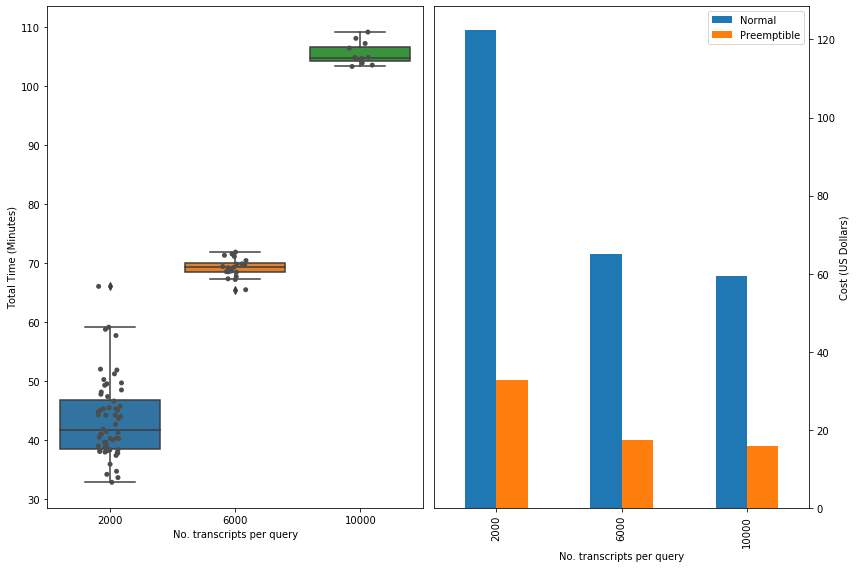

In [240]:
data = []
for p in jobs['total']['Query'].unique():
    data.append([jobs['total'][jobs['total']['Query'] == p]['Time'].sum()/60 * PRICE['n2'][64],
                jobs['total'][jobs['total']['Query'] == p]['Time'].sum()/60 * PREEMPTIBLE_PRICE['n2'][64],
                 p])
cost = pandas.DataFrame(data, columns=['Normal', 'Preemptible', 'Query'])
cost.to_csv(os.path.join(result_dir,'gcp_cost_120k.tsv'), sep='\t', index=None)  

fig, ax = plt.subplots(figsize=(12,8), ncols=2)

box_plot = sns.boxplot(x="Query", y="Time", data=jobs['total'], ax=ax[0])
sns.stripplot(x="Query", y="Time", data=jobs['total'], jitter=True, color=".3", ax=ax[0])

ax[0].set_ylabel("Total Time (Minutes)")
ax[0].set_xlabel("No. transcripts per query")

cost.plot(x="Query", kind="bar", ax=ax[1])
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("Cost (US Dollars)")
ax[1].set_xlabel("No. transcripts per query")

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels)
fig.tight_layout()

In [239]:
!ls {result_dir}

10000  6000		  aws_total_120k.tsv  gcp_total_120k.tsv
2000   aws_cost_120k.tsv  gcp_cost_120k.tsv
